In [ ]:
# Data have been published by science group from Norway
# [1] https://www.nature.com/articles/s41597-025-04384-3 
# [2] https://doi.org/10.5281/zenodo.13754984
# 
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / 'src'
# kaggle data: https://www.kaggle.com/datasets/nikitamanaenkov/psychiatric-motor-activity-dataset
DATA_RAW_DIR_kaggle = PROJECT_ROOT / 'data' / 'raw' / 'psychiatric-motor-activity-dataset'
# zenodo Data Version 1:
DATA_RAW_DIR_zenodo_v1 = PROJECT_ROOT / 'data' / 'raw' / 'OBF-Psychiatric-Dataset_v1'
# zenodo Data Version 2:
DATA_RAW_DIR_zenodo_v2 = PROJECT_ROOT / 'data' / 'raw' / 'OBF-Psychiatric-Dataset_v2'

DATA_RAW_DIR = DATA_RAW_DIR_kaggle  # switch here for testing the other versions

sys.path.append(str(SRC_DIR))
from core.pma_base import PMActivity
from core.pma_base import PMADataADHDKaggle
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
# Set of features used for base model in [1]
FEATURES = DATA_RAW_DIR / 'features.csv'
df_features_nature=pd.read_csv(FEATURES)
df_features_nature.head(n=10)
# Finding many days e.g. for 'control_1' have been taken from dataset 
# => check again after cleaning raw data

,user,mean,sd,pctZeros,median,q25,q75,class
0,control_1,185.568056,346.555786,38.680556,37.5,0.0,201.00,control
1,control_1,225.981250,384.378661,35.833333,53.0,0.0,248.00,control
2,control_1,169.663194,304.317895,45.625000,18.0,0.0,194.00,control
3,control_1,183.690972,277.006551,36.111111,106.0,0.0,184.00,control
4,control_1,347.075000,236.845868,2.361111,347.0,264.0,347.00,control
5,control_1,194.423611,356.423708,43.750000,20.0,0.0,194.00,control
6,control_1,310.715278,450.937392,35.763889,93.0,0.0,495.00,control
7,control_2,271.193056,360.034647,29.513889,136.0,0.0,394.00,control
8,control_2,462.234028,534.682651,27.569444,283.0,0.0,757.25,control
9,control_2,457.170139,591.562696,33.888889,156.0,0.0,801.00,control


In [61]:
# building features new from raw data for all days
import statistics as stat
from datetime import datetime
DATAFILE = DATA_RAW_DIR / 'control' / 'control_1.csv'
df_tmp = pd.read_csv(DATAFILE)
dates = df_tmp.loc[:,'date'].unique()
for d in ['2003-03-19']: #dates:
    mask= df_tmp.loc[:,'date'] == d
    if mask.sum() == 1440:
        activity = df_tmp.loc[mask,'activity']
        q25, median, q75 = stat.quantiles(activity, n=4)
        # print(activity.describe())
        # print(q25, median, q75)
        mean = stat.mean(activity)
        sd = stat.stdev(activity)
        # print(mean,sd)
        pctZeros = 100 * (activity == 0).mean()
        # print(pctZeros)

df_features_selfmade = pd.DataFrame(columns=['user', 'mean', 'sd', 'pctZeros', 
                            'median', 'q25', 'q75', 'class', 'date', 'weekday'])

diags  = ['adhd', 'clinical', 'control', 'depression', 'schizophrenia']
pat_lists = {}
max_npat = 0
for diag in diags:
    df = pd.read_csv(DATA_RAW_DIR / f"{diag}-info.csv")
    pat_lists[diag] = list(df.loc[:,'number'])
    #print(pat_lists[diag])
    npat = len(pat_lists[diag])
    max_npat = max(max_npat, npat)

for idiag in range(len(diags)):
    diag = diags[idiag]
    pat_list = pat_lists[diag]
    #print(pat_list)
    pat_id = pat_list[0]
    for ipat_id in range(len(pat_list)):
        pat_id = pat_list[ipat_id]
        DATAFILE = DATA_RAW_DIR / diag / f'{pat_id}.csv'
        df_tmp = pd.read_csv(DATAFILE)
        dates = df_tmp.loc[:,'date'].unique()
        for d in dates:
            mask= df_tmp.loc[:,'date'] == d
            if mask.sum() == 1440:
                activity = df_tmp.loc[mask,'activity']
                q25, median, q75 = stat.quantiles(activity, n=4)
                mean = stat.mean(activity)
                sd = stat.stdev(activity)
                pctZeros = 100 * (activity == 0).mean()
                weekday = datetime.strptime(str(d),'%Y-%m-%d').strftime('%A')
                df_features_selfmade.loc[len(df_features_selfmade)] = \
                    [pat_id, mean, sd, pctZeros, median, q25, q75, diag, d, weekday]


df_features_selfmade.head()


,user,mean,sd,pctZeros,median,q25,q75,class,date,weekday
0,adhd_1,54.134028,101.653198,46.180556,5.0,0.0,65.0,adhd,2009-02-24,Tuesday
1,adhd_1,9.389583,41.273697,88.541667,0.0,0.0,0.0,adhd,2009-02-25,Wednesday
2,adhd_1,29.054861,78.145117,72.152778,0.0,0.0,5.0,adhd,2009-02-26,Thursday
3,adhd_1,99.136806,159.225772,46.319444,3.0,0.0,147.0,adhd,2009-02-27,Friday
4,adhd_1,41.240972,85.954516,54.236111,0.0,0.0,48.0,adhd,2009-02-28,Saturday


In [ ]:
# check for differences between delivered features and own calculation
# => no adhd data
# => deletion of lines which look ok at first sight, e.g only 7 days for control_1
pat_id='control_1'
mask = df_features_selfmade.loc[:,'user'] == pat_id
print(df_features_selfmade.loc[mask,['user', 'mean', 'sd', 'pctZeros', 
                            'median', 'q25', 'q75']].head(10))
print(df_features_nature.loc[:,['user', 'mean', 'sd', 'pctZeros', 
                            'median', 'q25', 'q75']].head(10))
(df_features_nature.loc[:,'user'] == 'adhd_1').sum()

          user        mean          sd   pctZeros  median    q25    q75
502  control_1  185.568056  346.555786  38.680556    37.5    0.0  201.0
503  control_1  225.981250  384.378661  35.833333    53.0    0.0  248.0
504  control_1  169.663194  304.317895  45.625000    18.0    0.0  194.0
505  control_1  183.690972  277.006551  36.111111   106.0    0.0  184.0
506  control_1  347.075000  236.845868   2.361111   347.0  264.0  347.0
507  control_1  194.423611  356.423708  43.750000    20.0    0.0  194.0
508  control_1  310.715278  450.937392  35.763889    93.0    0.0  495.0
509  control_1  199.518750  365.761889  48.680556     3.0    0.0  273.0
510  control_1  183.131944  319.061505  40.208333    27.0    0.0  201.0
511  control_1  218.872222  391.002171  44.791667    22.0    0.0  223.0
        user        mean          sd   pctZeros  median    q25     q75
0  control_1  185.568056  346.555786  38.680556    37.5    0.0  201.00
1  control_1  225.981250  384.378661  35.833333    53.0    0.0  24

np.int64(0)

[np.float64(0.6778457464465202), np.float64(0.732882882882883), np.float64(0.6875715958433442)]
[np.float64(0.4187218161784694), np.float64(0.5726495726495726), np.float64(0.47033080843735586)]
[np.float64(0.569058430008273), np.float64(0.7078347578347579), np.float64(0.6144682640646268)]


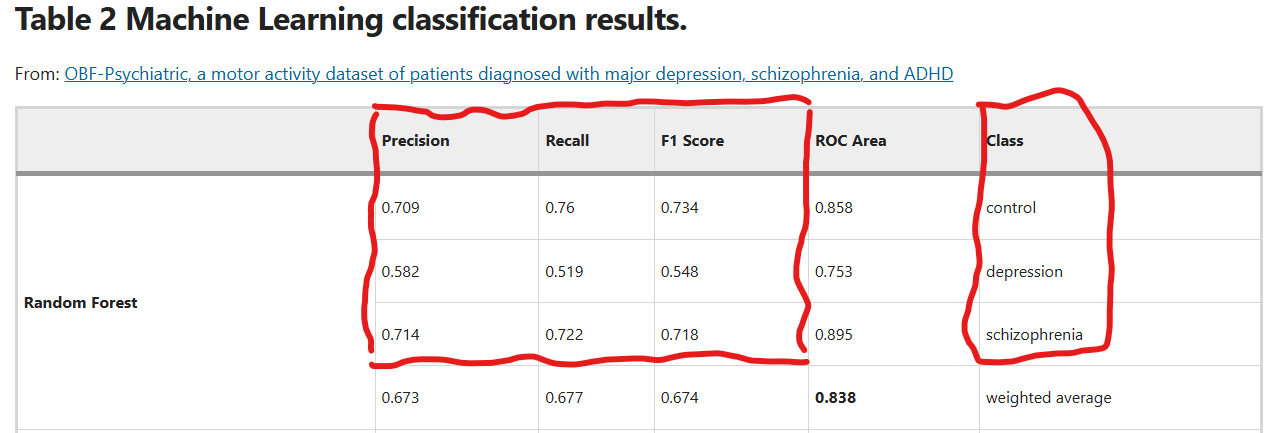

In [80]:
from sklearn.ensemble      import RandomForestClassifier

model_forest = RandomForestClassifier(class_weight = 'balanced', 
                                     random_state = 42,
                                     max_depth = 4 )

features = df_features_nature.loc[:,['mean', 'sd', 'pctZeros', 
                                     'median', 'q25', 'q75']]
target_control = df_features_nature.loc[:,'class'] == 'control'
target_control.sum()
target_depression = df_features_nature.loc[:,'class'] == 'depression'
target_depression.sum()
target_schizophrenia = df_features_nature.loc[:,'class'] == 'schizophrenia'
target_schizophrenia.sum()

#model.fit(features, target_train)


from sklearn.model_selection import cross_val_score

for target in [target_control, target_depression, target_schizophrenia]:
    score_set =[]
    for score in ['precision', 'recall', 'f1']:
        cv_results = cross_val_score(
                                estimator = model_forest,
                                        X = features,
                                        y = target,
                                  scoring = score,
                                       cv = 10, n_jobs=-1
                            )
        score_set.append(cv_results.mean())
        #print('cv_results mean = ', cv_results.mean())
    print(score_set)

from IPython.display import Image, display

display(Image(filename='RF_results_Nature.png'))

The scores reported for 10-fold cross validation show similar tendencies like those calculated above
and the differences are not large.

## Repetition with own (non-cleaned) features

In [81]:
features = df_features_selfmade.loc[:,['mean', 'sd', 'pctZeros', 
                                     'median', 'q25', 'q75']]
target_control = df_features_selfmade.loc[:,'class'] == 'control'
target_depression = df_features_selfmade.loc[:,'class'] == 'depression'
target_schizophrenia = df_features_selfmade.loc[:,'class'] == 'schizophrenia'
target_adhd = df_features_selfmade.loc[:,'class'] == 'adhd'
target_clinical = df_features_selfmade.loc[:,'class'] == 'clinical'

for target in [target_control, target_depression, target_schizophrenia, target_adhd, target_clinical]:
    score_set =[]
    for score in ['precision', 'recall', 'f1']:
        cv_results = cross_val_score(
                                estimator = model_forest,
                                        X = features,
                                        y = target,
                                  scoring = score,
                                       cv = 10, n_jobs=-1
                            )
        score_set.append(cv_results.mean())
    print(score_set)


[np.float64(0.5783860867298908), np.float64(0.664179104477612), np.float64(0.611206578016769)]
[np.float64(0.2567772003241042), np.float64(0.525952380952381), np.float64(0.3355704509317439)]
[np.float64(0.38830428611527557), np.float64(0.6676470588235295), np.float64(0.47232178080424025)]
[np.float64(0.19584096517598676), np.float64(0.7556923076923077), np.float64(0.3070633460525375)]
[np.float64(0.14007191729463941), np.float64(0.5663333333333334), np.float64(0.22195531318724243)]


The scores are much lower. 

## Cleaning the features

### 1st step: eliminate days with many zeros => actimeter not worn by person.

In [85]:
threshold_zeros = 50 # %  =>  percentage of zeros accepted
mask_zeros50 = df_features_selfmade.loc[:, 'pctZeros'] <= 50

print(f'{mask_zeros50.mean() = }')

features = df_features_selfmade.loc[mask_zeros50,['mean', 'sd', 'pctZeros', 
                                     'median', 'q25', 'q75']]
target_control       = df_features_selfmade.loc[mask_zeros50,'class'] == 'control'
target_depression    = df_features_selfmade.loc[mask_zeros50,'class'] == 'depression'
target_schizophrenia = df_features_selfmade.loc[mask_zeros50,'class'] == 'schizophrenia'
target_adhd          = df_features_selfmade.loc[mask_zeros50,'class'] == 'adhd'
target_clinical      = df_features_selfmade.loc[mask_zeros50,'class'] == 'clinical'

for target in [target_control, target_depression, target_schizophrenia, target_adhd, target_clinical]:
    score_set =[]
    for score in ['precision', 'recall', 'f1']:
        cv_results = cross_val_score(
                                estimator = model_forest,
                                        X = features,
                                        y = target,
                                  scoring = score,
                                       cv = 5, n_jobs=-1
                            )
        score_set.append(cv_results.mean())
    print(score_set)

mask_zeros50.mean() = np.float64(0.7573490112239444)
[np.float64(0.5335283985248177), np.float64(0.6233580810965164), np.float64(0.5689312380400522)]
[np.float64(0.23703197951785526), np.float64(0.4930196078431372), np.float64(0.3070476477279601)]
[np.float64(0.33362520457859257), np.float64(0.6436323366555924), np.float64(0.4361541500785657)]
[np.float64(0.17556470449614983), np.float64(0.5697584541062801), np.float64(0.2656012230840606)]
[np.float64(0.13724621164155165), np.float64(0.4473975636766334), np.float64(0.201712158275931)]


The dataset is reduced by ~25 % by eliminating days with more than 50 % zeros.
The scores mostly drop significantly.
Further cleaning assumed to be a key - beside new features.